In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 8*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-02-19 21:45:03.833911: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 21:45:04.103087: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-19 21:45:04.841659: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

# Note to remember
# In this form of reshaping the datasets, u, u_xx, u_yy, u_t, v, v_xx and v_yy, v_t must be transposed to correctly show x and y coordinates

# This note book use only one snapshot (the last), does not estimate the time derivatives and use the exact u and v to reduce the loss residual. FInaly, the parameters are constant.

In [3]:
sim_name = "Koch_Meinhardt_5"
x_slice=slice(0,100,1)#slice(30,65,1)#slice(0,100,1)#slice(30,65,1)#slice(50,65,1)#
y_slice=slice(0,100,1)#slice(50,85,1)#slice(0,100,1)#slice(50,85,1)#slice(70,85,1)#
pattern = load(sim_name, x_slice, y_slice,
               data_time_start=-3,
               data_time_len=2,
               data_time_step=1)

x_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[0]
y_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[1]
x_range = x_range[x_slice]
y_range = y_range[y_slice]

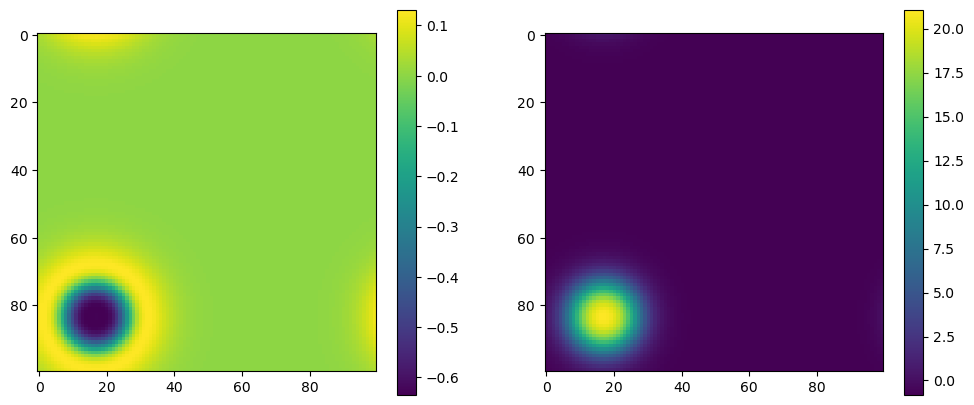

In [4]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(pattern.params["D_u"]*(pattern.c_xx[0,:, : , -1] + pattern.c_yy[0,:, : , -1]) - pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(122)
plt.imshow(pattern.params["D_v"]*(pattern.c_xx[1,:, : , -1] + pattern.c_yy[1,:, : , -1]) - pattern.c_t[1,:, : , -1])
plt.colorbar()

In [5]:
x = tf.constant(x_range, dtype=tf.float32)
y = tf.constant(y_range, dtype=tf.float32)
# The order of the Y and X must be reversed,
# since the chnages the value finds the derivatives
#Y, X = tf.meshgrid(x, y)
X, Y = tf.meshgrid(x, y)
ts = tf.constant(pattern.t_star[-1:], dtype=tf.float32)
T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
def H_cube(X, Y, T):
    return tf.concat(
            [
                tf.concat(
                    [
                        X[tf.newaxis, :, :, tf.newaxis],
                        Y[tf.newaxis, :, :, tf.newaxis],
                        T[:, :, i : i + 1][tf.newaxis, :, :, :],
                    ],
                    axis=3,
                )
                for i in range(T.shape[-1])
            ],
            axis=0,
        )
H = H_cube(X, Y, T)

#      Periodic boundary condition
X_R = tf.concat([X[:, 1:] ,  X[:, 0:1]], axis=1)
X_L = tf.concat([X[:, -1:], X[:, :-1]], axis=1)
Y_D = tf.concat([Y[1:, :] ,  Y[0:1, :]], axis=0)
Y_U = tf.concat([ Y[1:, :], Y[0:1, :]], axis=0)


    
H_R = H_cube(X_R, Y, T)
H_L = H_cube(X_L, Y, T)
H_D = H_cube(X, Y_D, T)
H_U = H_cube(X, Y_U, T)

In [6]:
H.shape

TensorShape([1, 100, 100, 3])

In [7]:
# Data is a three column matrix as (x,y,t), where
# first x changes, then y, and finally t (like Boolean tables)
data = tf.reshape(H, (H.shape[0]*H.shape[1]*H.shape[2],3))

data_R = tf.reshape(H_R, (H_R.shape[0]*H_R.shape[1]*H_R.shape[2],3))
data_L = tf.reshape(H_L, (H_L.shape[0]*H_L.shape[1]*H_L.shape[2],3))
data_D = tf.reshape(H_D, (H_D.shape[0]*H_D.shape[1]*H_D.shape[2],3))
data_U = tf.reshape(H_U, (H_U.shape[0]*H_U.shape[1]*H_U.shape[2],3))

In [8]:
def concentration_to_data(c):
    # Select the last time step
    # and reorder the x and y to match it
    # with H
    c_copy = np.einsum("cxy -> cyx", c[..., -1].copy())
    #reshape c to flatten the data for each species
    c = c_copy.reshape((2, pattern.c.shape[1]*pattern.c.shape[2]))
    # and finnaly use its transposed, to have the each speacices in on column 
    c = c.T
    return c

c = concentration_to_data(pattern.c)
c_xx = concentration_to_data(pattern.c_xx)
c_yy = concentration_to_data(pattern.c_yy)
c_t = concentration_to_data(pattern.c_t)
    
def gen_series():    
    
    for i in range(data.shape[0]):
        h = data[i,:]
        yield h, c[i,:], c_xx[i,:], c_yy[i,:]    
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32, tf.float32, tf.float32), 
                                    output_shapes=((3,),(2,),(2,),(2,)))

In [9]:
class NN2(tu.NN):
    def build(self):
        """Create the state of the layers (weights)"""
        self.weights = []
        self.scales = []
        self.biases = []
        for i in range(0, self.num_layers - 1):
            W = self.xavier_init(size=[self.layers[i], self.layers[i + 1]])
            a = tf.Variable(tf.ones([1, self.layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            b = tf.Variable(tf.zeros([1, self.layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            self.weights.append(W)
            self.scales.append(a)
            self.biases.append(b)
        
        
    @tf.function
    def net(self, inputs):
        # Map the inputs to the range [-1, 1]
        H = 2.0 * (inputs - self.lb) / (self.ub - self.lb) - 1.0
        for W, a ,b in zip(self.weights[:-1], self.scales[:-1], self.biases[:-1]):
            outputs = tf.matmul(H, W)
            H = tf.tanh(a*outputs + b)

        W = self.weights[-1]
        a = self.scales[-1]
        b = self.biases[-1]
        outputs = tf.matmul(H, W)
        outputs = a*outputs + b*b/2.0
        return outputs

In [10]:
@tf.function
def grads(pinn, inputs):    
    with tf.GradientTape(persistent=True) as tape:        
        tape.watch(inputs)      
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(inputs)            
            outputs = pinn.net(inputs)            
        
            u = tf.squeeze(outputs[:, 0])
            v = tf.squeeze(outputs[:, 1])
            
            grad_u = tape2.gradient(u, inputs)
            u_x = grad_u[:, 0]
            u_y = grad_u[:, 1]
            u_t = grad_u[:, 2]
            
            grad_v = tape2.gradient(v, inputs)
            v_x = grad_v[:, 0]
            v_y = grad_v[:, 1]
            v_t = grad_v[:, 2]
                    
        grad_u_x = tape.gradient(u_x, inputs)
        u_xx = grad_u_x[:, 0]
        #u_yx = grad_u_x[:, :, :, 1]
        #u_tx = grad_u_x[:, :, :, 2]
        grad_u_y = tape.gradient(u_y, inputs)
        #u_xy = grad_u_y[:, :, :, 0]
        u_yy = grad_u_y[:, 1]
        #u_ty = grad_u_y[:, :, :, 2]
        grad_v_x = tape.gradient(v_x, inputs)
        v_xx = grad_v_x[:, 0]
        #v_yx = grad_v_x[:, :, :, 1]
        #v_tx = grad_v_x[:, :, :, 2]
        grad_v_y = tape.gradient(v_y, inputs)
        #v_xy = grad_v_y[:, :, :, 0]
        v_yy = grad_v_y[:, 1]
        #v_ty = grad_v_y[:, :, :, 2]
                                     
    return (tf.squeeze(u),
            tf.squeeze(u_xx), tf.squeeze(u_yy), tf.squeeze(u_t),
            tf.squeeze(v),
            tf.squeeze(v_xx), tf.squeeze(v_yy), tf.squeeze(v_t))


In [11]:
std_factor = 1.0
theta_star = np.array([pattern.params["rho_u"], pattern.params["sigma_u"],
                       pattern.params["mu_u"], pattern.params["kappa_u"],
                       pattern.params["rho_v"], pattern.params["sigma_v"]])



In [12]:
scale=theta_star*std_factor
scale[scale==0]=1
theta = np.random.normal(theta_star, scale=scale)
theta = np.abs(theta)
s_theta = normalise(theta - theta_star)
theta_line = creat_line(theta_star, s_theta)
theta_end = Euc_L(theta - theta_star)
theta_line_steps = np.linspace(0, theta_end, 4)
theta_line_params = np.array([ theta_line(t) for t in theta_line_steps])
print(theta_end)

3.433561637136795


In [13]:
lb = tf.constant([x_range[0], y_range[0], pattern.t_star[0]], dtype=tf.float32)
ub =  tf.constant([x_range[-1], y_range[-1], pattern.t_star[-1]], dtype=tf.float32)
pinn = NN2([3, 128, 128, 2], lb, ub, tf.float32)
#optimizer=keras.optimizers.Adam(learning_rate=1e-2)   
optimizer=keras.optimizers.Adam(learning_rate=1e-3)
#optimizer=keras.optimizers.SGD(learning_rate=5e-4)   


In [14]:
actual_u_der = pattern.params["D_u"]*(pattern.c_xx[0,:, : , -1] + pattern.c_yy[0,:, : , -1]) - pattern.c_t[0,:, : , -1]
actual_v_der = pattern.params["D_v"]*(pattern.c_xx[1,:, : , -1] + pattern.c_yy[1,:, : , -1]) - pattern.c_t[1,:, : , -1]

def to(arr):
    return arr.numpy().reshape(y_range.shape[0], x_range.shape[0])

def clip_by_value_zero_lb(z):
    return tf.clip_by_value(z, 0, 1e10,)

D_u_val, D_v_val = pattern.params["D_u"], pattern.params["D_v"]
(rho_u_val, sigma_u_val, mu_u_val,
 kappa_u_val, rho_v_val, sigma_v_val)= theta_line_params[-1]

print("="*20)
print("D_u: ", D_u_val)
print("D_v: ", D_v_val)
print("rho_u: ", rho_u_val)
print("rho_v: ", rho_v_val) 
print("sigma_u: ", sigma_u_val)
print("sigma_v: ", sigma_v_val) 
print("mu_u: ", mu_u_val) 
print("kappa_u: ", kappa_u_val)

def create_tf_var(name, value, no_clip=False):
    if no_clip:
        return tf.Variable(value,
                       dtype=pinn.dtype,
                       name=name)
    else:
        return tf.Variable(value,
                       dtype=pinn.dtype,
                       name=name,
                       constraint=clip_by_value_zero_lb)

D_u = create_tf_var("D_u", D_u_val)    
D_v = create_tf_var("D_v", D_v_val)
rho_u = create_tf_var("rho_u", rho_u_val)    
rho_v = create_tf_var("rho_v", rho_v_val)
sigma_u = create_tf_var("sigma_u", sigma_u_val, no_clip=False)    
sigma_v = create_tf_var("sigma_v", sigma_v_val, no_clip=False)
mu_u = create_tf_var("mu_u", mu_u_val)    
kappa_u = create_tf_var("kappa_u", kappa_u_val)    
#     sigma_u2 = create_tf_var("sigma_u2", 0.0, no_clip=True)    
#     sigma_v2 = create_tf_var("sigma_v2", 0.0, no_clip=True)

@tf.function
def train_step_inverse(elements):
    with tf.GradientTape(persistent=True) as tape: 
        H = elements[0]
        tape.watch(H)
        trainables = pinn.trainable_variables + (rho_u, rho_v, sigma_u, sigma_v, mu_u, kappa_u)


        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(H)

            outputs = pinn.net(H)
            ug = tf.squeeze(outputs[:, 0])
            vg = tf.squeeze(outputs[:, 1])

            grad_u = tape2.gradient(ug, H)
            u_x = grad_u[:, 0]
            u_y = grad_u[:, 1]

            grad_v = tape2.gradient(vg, H)
            v_x = grad_v[:, 0]
            v_y = grad_v[:, 1]

        grad_u_x = tape.gradient(u_x, H)
        u_xx = grad_u_x[:, 0]
        grad_u_y = tape.gradient(u_y, H)
        u_yy = grad_u_y[:, 1]
        grad_v_x = tape.gradient(v_x, H)
        v_xx = grad_v_x[:, 0]
        grad_v_y = tape.gradient(v_y, H)
        v_yy = grad_v_y[:, 1]

        u = tf.squeeze(elements[1][:, 0])
        v = tf.squeeze(elements[1][:, 1])

        u_rhs = D_u * (u_xx + u_yy)# - u_t
        v_rhs = D_v * (v_xx + v_yy)# - v_t
        f = u * u * v / (1.0 + kappa_u * u * u)
        f_u = u_rhs + rho_u * f - mu_u * u + sigma_u
        f_v = v_rhs - rho_v * f + sigma_v
        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)


        act_u_xx = elements[2][:, 0]
        act_v_xx = elements[2][:, 1]
        act_u_yy = elements[3][:, 0]
        act_v_yy = elements[3][:, 1]
        # act_u_t = elements[4][:, 0]
        # act_v_t = elements[4][:, 1]

        act_u_rhs = D_u*(act_u_xx + act_u_yy)# - act_u_t
        act_v_rhs = D_v*(act_v_xx + act_v_yy)# - act_v_t

        l2_res_u_rhs = tf.reduce_sum((u_rhs-act_u_rhs)**2)
        l2_res_v_rhs = tf.reduce_sum((v_rhs-act_v_rhs)**2)


        l2 = l2_res_u + l2_res_v + 10*l2_res_u_rhs + 10*l2_res_v_rhs

    grads = tape.gradient(l2, trainables)
    optimizer.apply_gradients(zip(grads, trainables))
    return (l2_res_u, l2_res_v, l2_res_u_rhs, l2_res_v_rhs)

D_u:  0.02
D_v:  1.0
rho_u:  0.6963277663642209
rho_v:  6.047587429917792
sigma_u:  0.12053258901510014
sigma_v:  1.775400139774792
mu_u:  1.0234816630471364
kappa_u:  1.3459301153597383


In [15]:
batch_size = 5000
def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}, "
            f" total loss: {np.sum(losses)}"
            f"  u: {losses[0]},  v: {losses[1]}\n"
            f" rhs  u: {losses[2]}, rhs v: {losses[3]}"
           ) 
    printer(f"rho_u: {rho_u.numpy()}, rho_v: {rho_v.numpy()},"
           f"sigma_u: {sigma_u.numpy()}, sigma_v: {sigma_v.numpy()} \n"
           f"mu_u: {mu_u.numpy()}, kappa_u: {kappa_u.numpy()}")

In [16]:
def plot_state():
    (u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t) = grads(pinn, data)

    u_der = pattern.params["D_u"]*( to(u_xx) + to(u_yy))# - to(u_t2)[-1, ...]
    v_der = pattern.params["D_v"]*( to(v_xx)+ to(v_yy))# - to(v_t2)[-1, ...]
    # X and Y are misoriented
    u_der = u_der.T
    v_der = v_der.T

    u = pattern.c[0,:, : , -1]
    v = pattern.c[1,:, : , -1]
    f = u * u * v / (1.0 + kappa_u * u * u)
    f_u =    rho_u * f - mu_u * u + sigma_u
    f_v =  - rho_v * f + sigma_v
    plot_n_im([to(u_xx).T, pattern.c_xx[0,:, : , -1], to(u_yy).T, pattern.c_yy[0,:, : , -1]], 
      ["u_xx", "Actual u_xx", "u_yy", "Actual u_yy"],          
      figsize=(12, 3)); plt.tight_layout()

    plot_n_im([to(v_xx).T, pattern.c_xx[1,:, : , -1], to(v_yy).T, pattern.c_yy[1,:, : , -1]],
              ["v_xx", "Actual v_xx", "v_yy", "Actual v_yy"],          
              figsize=(12, 3)); plt.tight_layout()
    plot_n_im([to(u_t).T,  pattern.c_t[0,:, : , -1],  to(v_t).T,  pattern.c_t[1,:, : , -1]],
              ["u_t", "Actual u_t", "v_t", "Actual v_t"],          
              figsize=(12, 3)); plt.tight_layout()
    plot_n_im([u_der,  actual_u_der],
              ["RHS U", "Actual RHS U"],          
              figsize=(12, 3)); plt.tight_layout()
    plot_n_im([v_der,  actual_v_der],
              ["RHS V", "Actual RHS V"],          
              figsize=(12, 3)); plt.tight_layout()
    plt.show()



Start of epoch 0


2023-02-19 21:46:11.494660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-19 21:46:11.509937: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f62aa6c9a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-19 21:46:11.509989: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2023-02-19 21:46:11.522353: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-19 21:46:12.012384: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


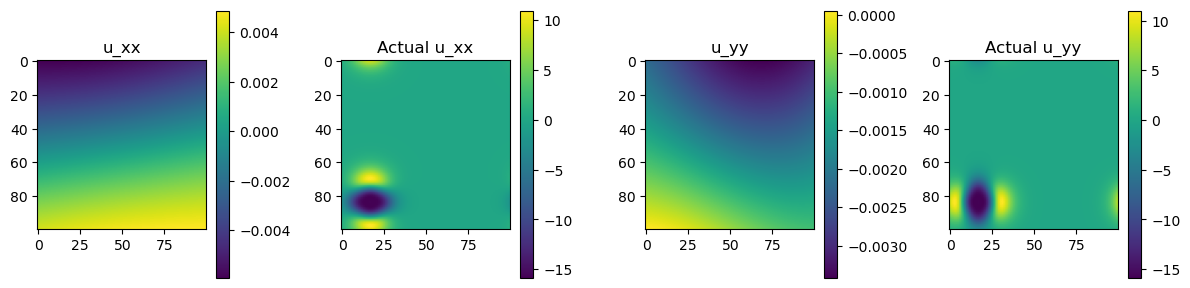

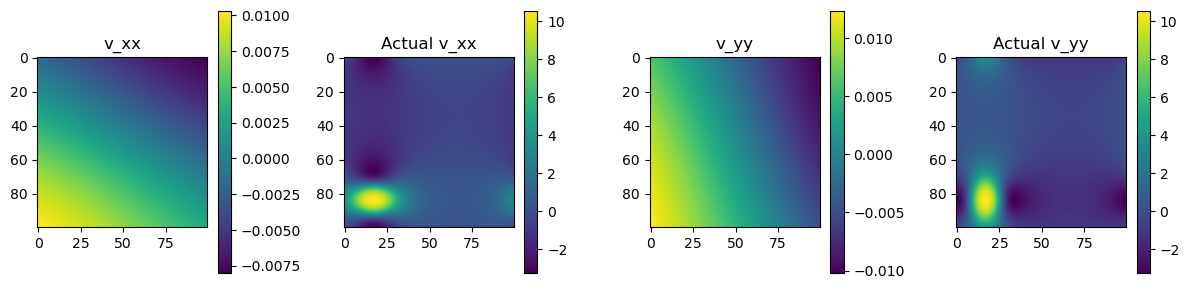

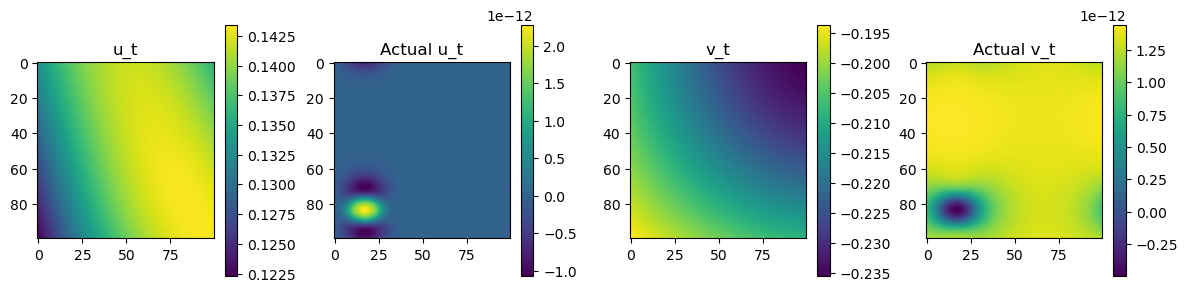

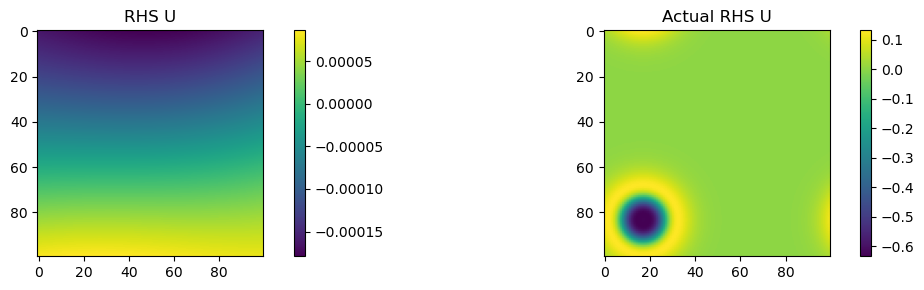

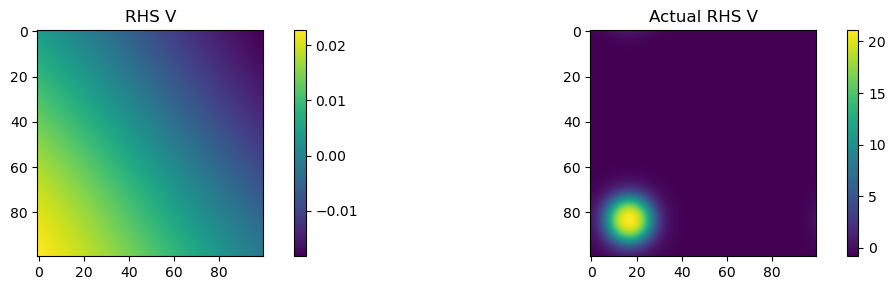

at epoch 0,  total loss: 117867.92137300968  u: 429.53338527679443,  v: 26001.2978515625
 rhs  u: 78.90068304538727, rhs v: 91358.189453125
rho_u: 0.6979743242263794, rho_v: 6.046087265014648,sigma_u: 0.12175585329532623, sigma_v: 1.7734895944595337 
mu_u: 1.0218356847763062, kappa_u: 1.34759521484375
Time taken: 33.16s

Start of epoch 500
at epoch 500,  total loss: 12060.875062942505  u: 123.48544669151306,  v: 11683.686065673828
 rhs  u: 7.3397581577301025, rhs v: 246.3637924194336
rho_u: 0.8465116620063782, rho_v: 6.639736652374268,sigma_u: 0.0018611836712807417, sigma_v: 1.2497886419296265 
mu_u: 0.6899727582931519, kappa_u: 0.6066688895225525
Time taken: 36.44s

Start of epoch 1000
at epoch 1000,  total loss: 6412.802508711815  u: 66.50276970863342,  v: 6230.3931884765625
 rhs  u: 3.7934476137161255, rhs v: 112.11310291290283
rho_u: 0.5512039661407471, rho_v: 6.3558669090271,sigma_u: 0.027251753956079483, sigma_v: 1.4165451526641846 
mu_u: 0.6438164710998535, kappa_u: 0.3296444714

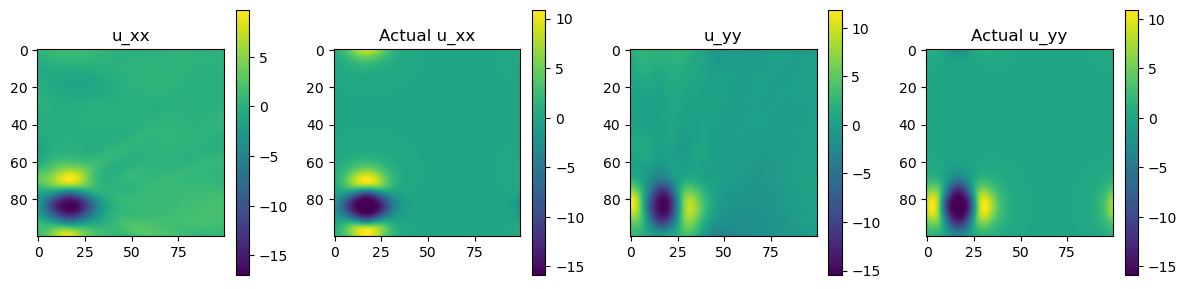

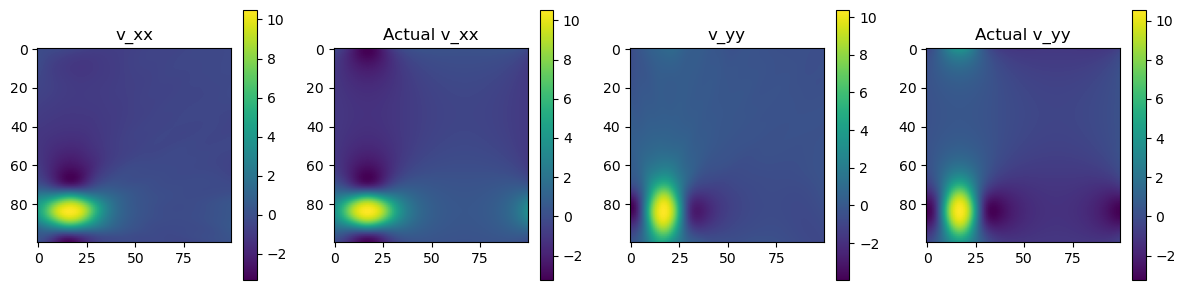

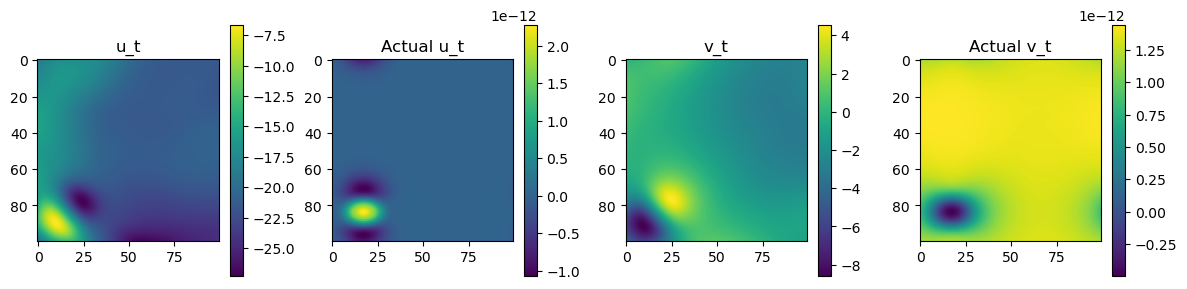

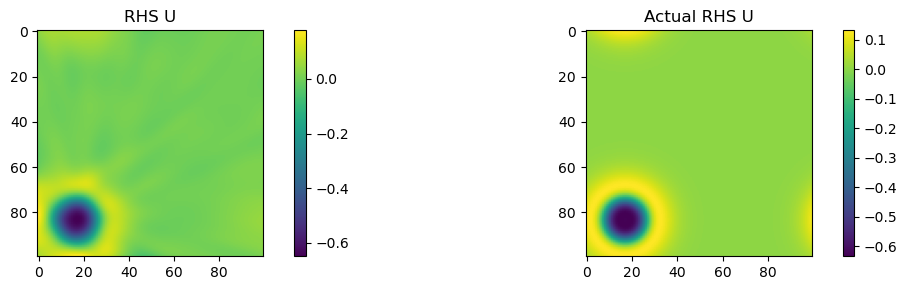

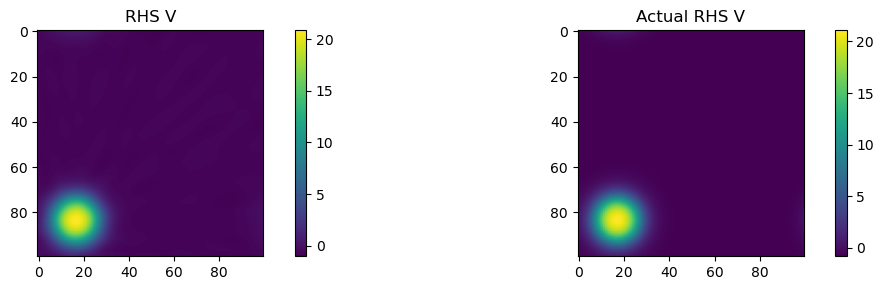

at epoch 2000,  total loss: 3424.09219032526  u: 33.0425591468811,  v: 3277.5228118896484
 rhs  u: 2.418072760105133, rhs v: 111.10874652862549
rho_u: 0.3189118206501007, rho_v: 5.112152576446533,sigma_u: 0.01325689535588026, sigma_v: 1.3080549240112305 
mu_u: 0.4018429219722748, kappa_u: 0.19046111404895782
Time taken: 36.88s

Start of epoch 2500
at epoch 2500,  total loss: 1934.074836730957  u: 24.16895091533661,  v: 1863.5192489624023
 rhs  u: 1.8633509874343872, rhs v: 44.52328586578369
rho_u: 0.2666548490524292, rho_v: 4.479585647583008,sigma_u: 0.012290585786104202, sigma_v: 1.229029655456543 
mu_u: 0.3638802468776703, kappa_u: 0.1278717815876007
Time taken: 34.79s

Start of epoch 3000
at epoch 3000,  total loss: 856.5055702030659  u: 15.683201372623444,  v: 810.6189231872559
 rhs  u: 1.5503856837749481, rhs v: 28.65305995941162
rho_u: 0.2815913259983063, rho_v: 3.89619517326355,sigma_u: 0.027276858687400818, sigma_v: 1.1478582620620728 
mu_u: 0.4708121120929718, kappa_u: 0.07436

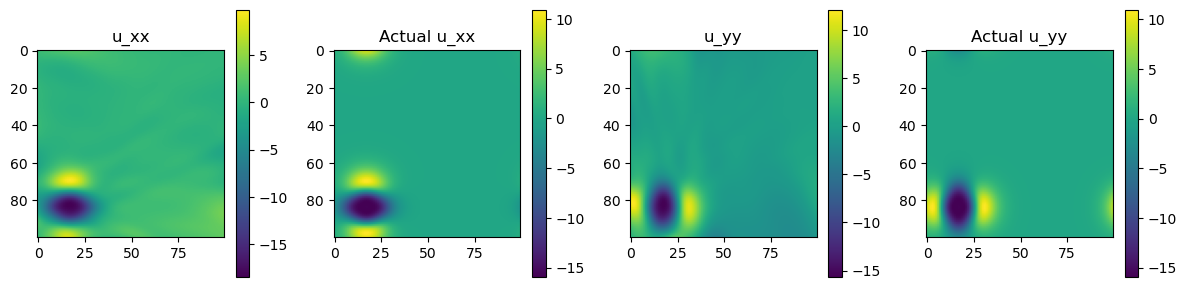

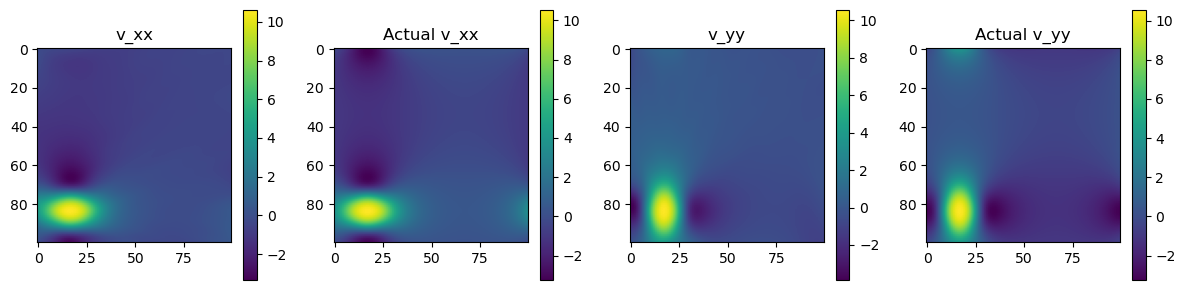

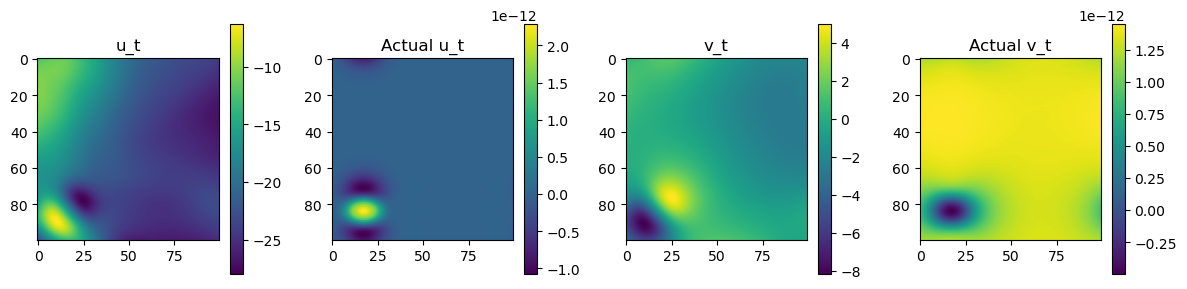

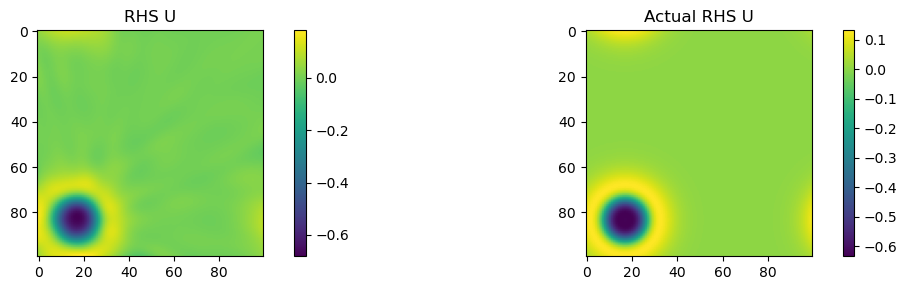

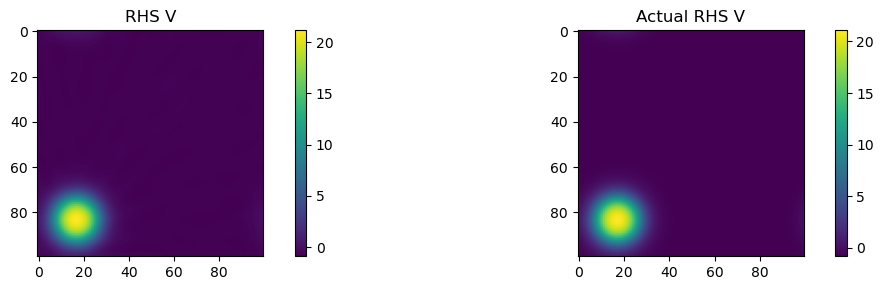

at epoch 4000,  total loss: 70.99019427597523  u: 1.30347540974617,  v: 42.191930294036865
 rhs  u: 1.014012262225151, rhs v: 26.48077630996704
rho_u: 0.38286566734313965, rho_v: 3.111773729324341,sigma_u: 0.08736583590507507, sigma_v: 1.0205219984054565 
mu_u: 0.9119391441345215, kappa_u: 0.008775971829891205
Time taken: 38.57s

Start of epoch 4500
at epoch 4500,  total loss: 48.978541880846024  u: 0.7351867258548737,  v: 23.859189987182617
 rhs  u: 0.7696913480758667, rhs v: 23.614473819732666
rho_u: 0.3904746472835541, rho_v: 3.0086147785186768,sigma_u: 0.09585381299257278, sigma_v: 1.0015792846679688 
mu_u: 0.9681203365325928, kappa_u: 0.0007663650321774185
Time taken: 35.99s

Start of epoch 5000
at epoch 5000,  total loss: 25.444731950759888  u: 0.5678619518876076,  v: 12.147367477416992
 rhs  u: 0.5860956534743309, rhs v: 12.143406867980957
rho_u: 0.39070960879325867, rho_v: 2.999440908432007,sigma_u: 0.09641671925783157, sigma_v: 0.999740481376648 
mu_u: 0.9716218113899231, kapp

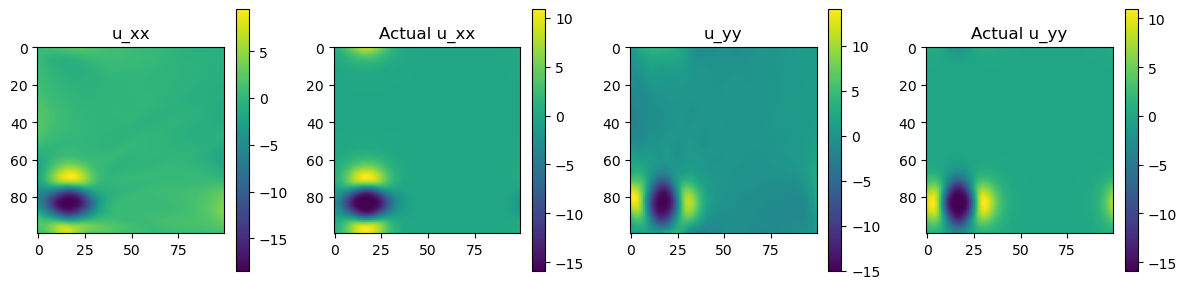

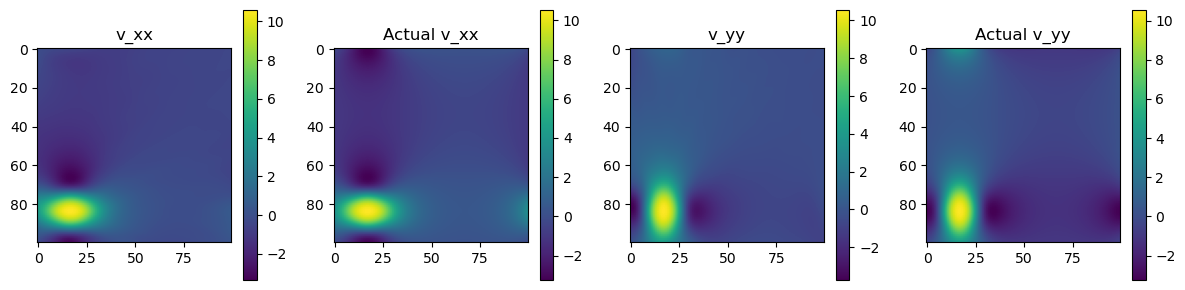

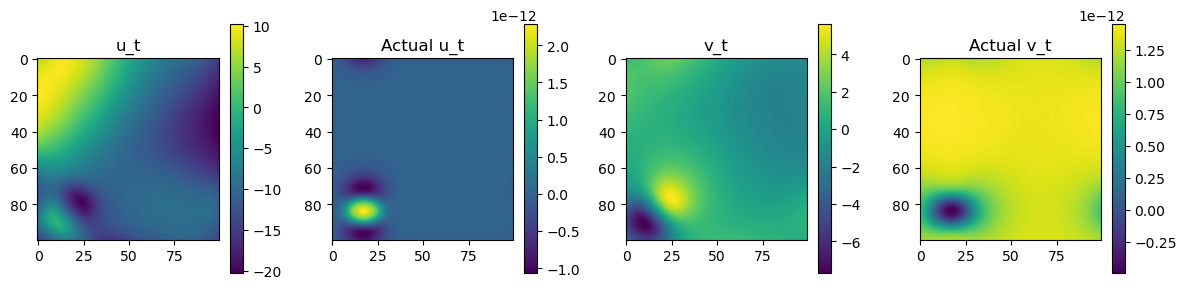

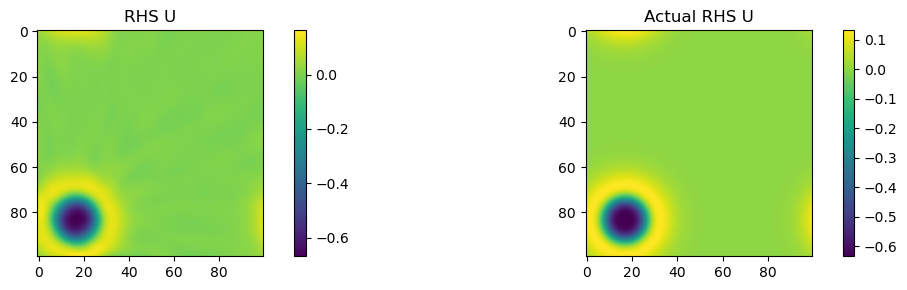

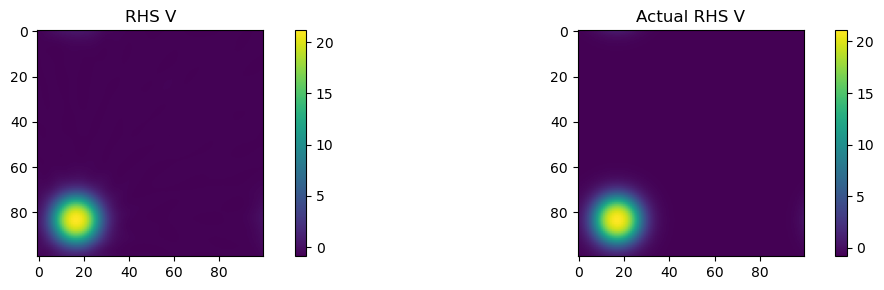

at epoch 6000,  total loss: 22.714659623801708  u: 0.34703176468610764,  v: 11.008757591247559
 rhs  u: 0.3521139621734619, rhs v: 11.00675630569458
rho_u: 0.39472195506095886, rho_v: 2.999509811401367,sigma_u: 0.09795725345611572, sigma_v: 0.9998323917388916 
mu_u: 0.9837204813957214, kappa_u: 0.0
Time taken: 39.93s

Start of epoch 6500
at epoch 6500,  total loss: 19.257618252187967  u: 0.3007577732205391,  v: 9.328156471252441
 rhs  u: 0.3037499748170376, rhs v: 9.32495403289795
rho_u: 0.3956885039806366, rho_v: 2.9996707439422607,sigma_u: 0.09841020405292511, sigma_v: 0.9998810291290283 
mu_u: 0.9868887066841125, kappa_u: 0.0
Time taken: 35.58s

Start of epoch 7000
at epoch 7000,  total loss: 15.056913383305073  u: 0.27039792388677597,  v: 7.258834362030029
 rhs  u: 0.2736813873052597, rhs v: 7.253999710083008
rho_u: 0.39612773060798645, rho_v: 2.9994707107543945,sigma_u: 0.09855148941278458, sigma_v: 0.9999311566352844 
mu_u: 0.9881399869918823, kappa_u: 0.0
Time taken: 35.89s

Sta

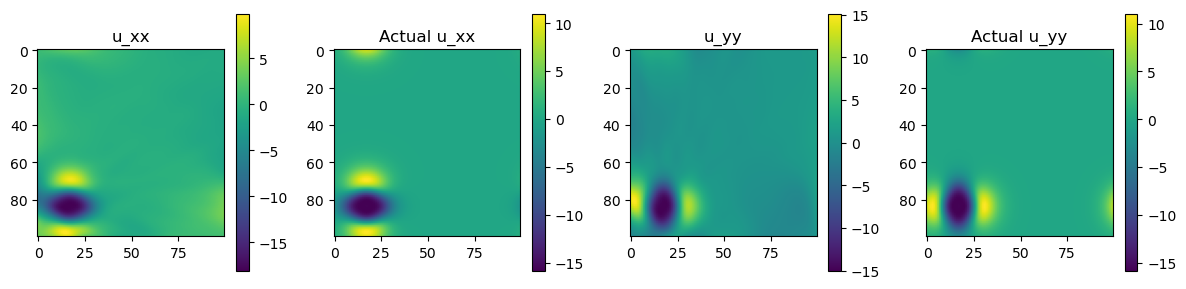

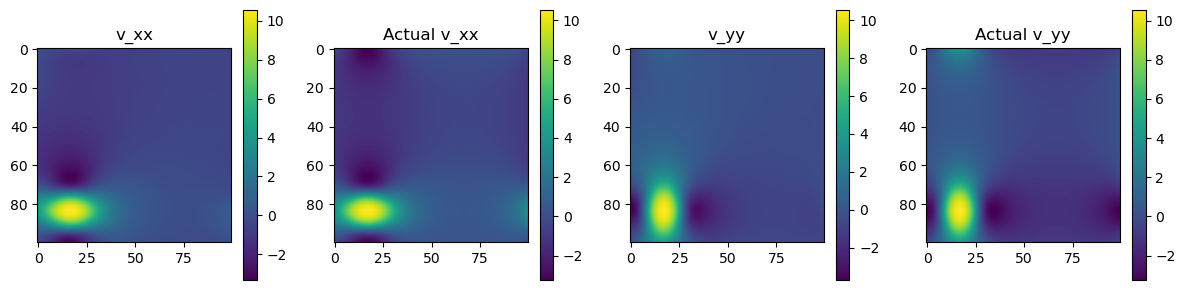

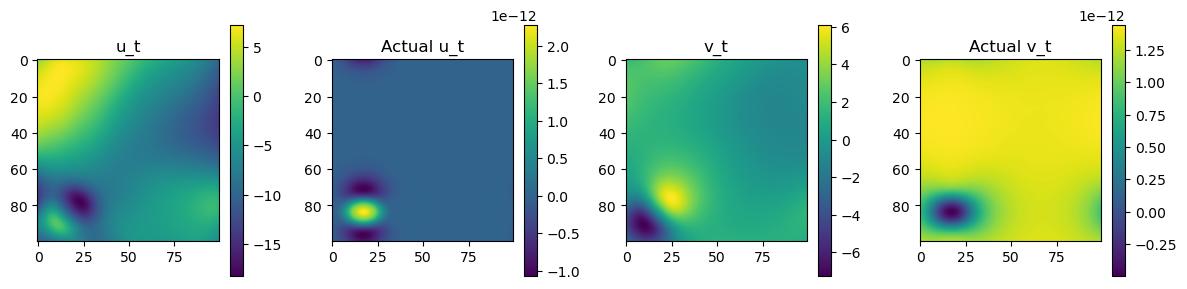

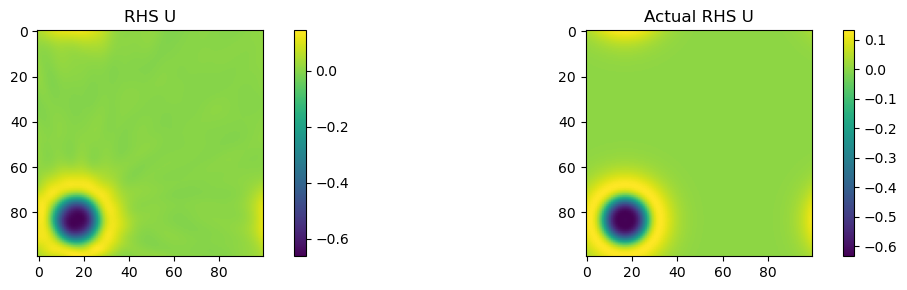

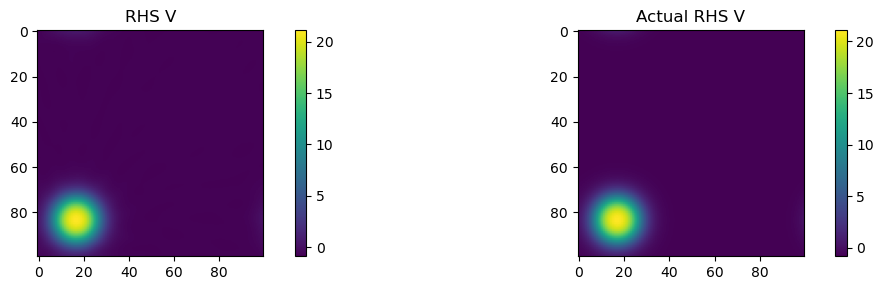

at epoch 8000,  total loss: 13.345236334949732  u: 0.23149195313453674,  v: 6.440028667449951
 rhs  u: 0.23407495394349098, rhs v: 6.439640760421753
rho_u: 0.3966314494609833, rho_v: 2.9998037815093994,sigma_u: 0.0987761840224266, sigma_v: 0.9999337792396545 
mu_u: 0.9898753762245178, kappa_u: 0.0
Time taken: 37.97s

Start of epoch 8500
at epoch 8500,  total loss: 20.221230410039425  u: 0.21193373575806618,  v: 9.900688648223877
 rhs  u: 0.21327902749180794, rhs v: 9.895328998565674
rho_u: 0.3972979187965393, rho_v: 2.9997432231903076,sigma_u: 0.09891416877508163, sigma_v: 0.9999129176139832 
mu_u: 0.9917645454406738, kappa_u: 0.0
Time taken: 35.73s

Start of epoch 9000
at epoch 9000,  total loss: 66.43425444886088  u: 0.2497604675590992,  v: 32.98722267150879
 rhs  u: 0.24584146589040756, rhs v: 32.95142984390259
rho_u: 0.39771950244903564, rho_v: 2.999244451522827,sigma_u: 0.09912476688623428, sigma_v: 0.9995903372764587 
mu_u: 0.9923452138900757, kappa_u: 0.0
Time taken: 35.06s

Sta

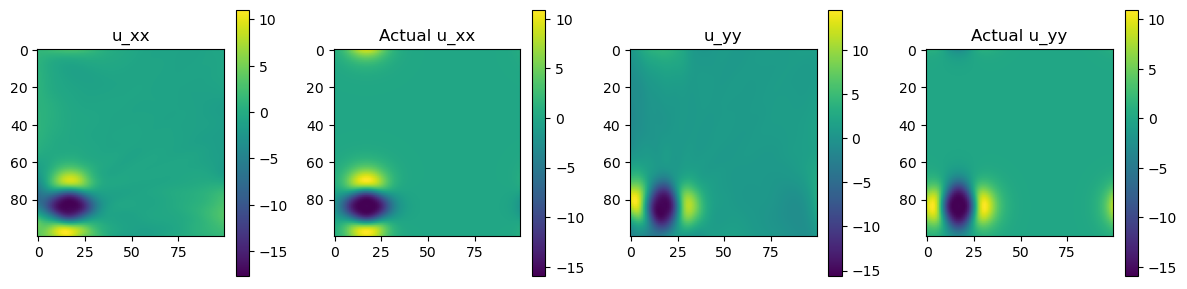

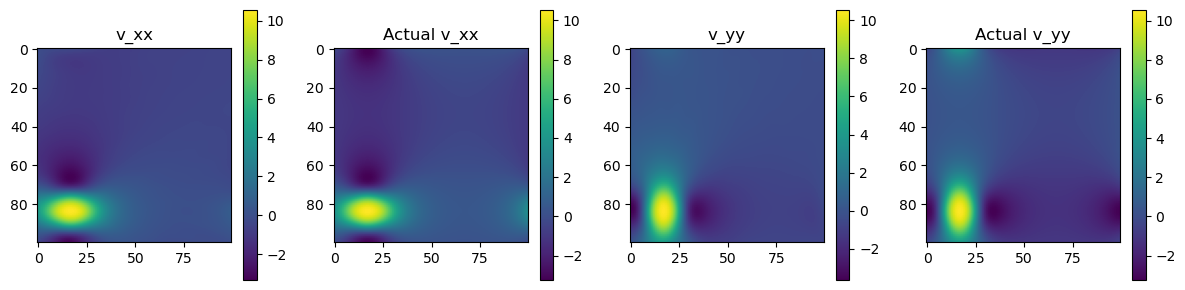

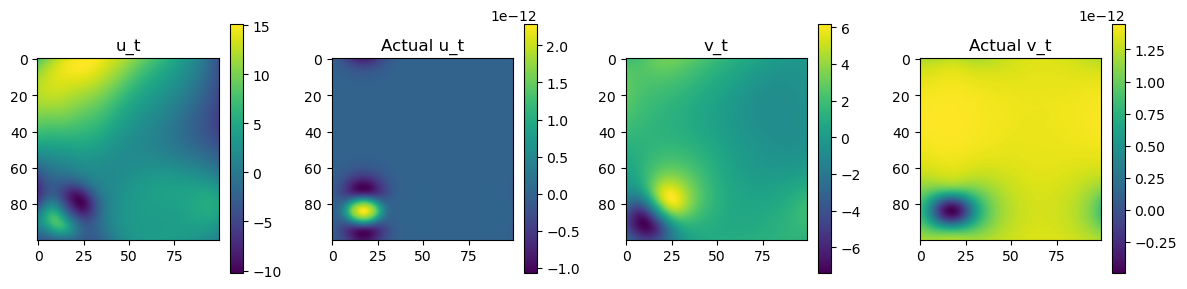

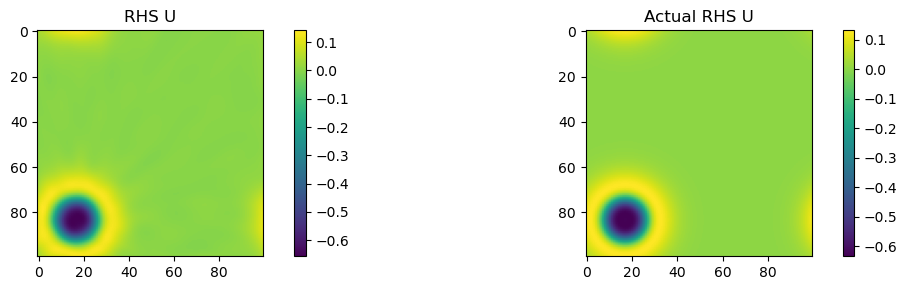

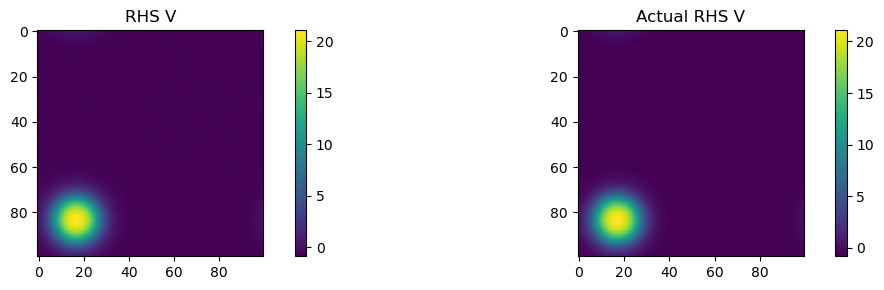

at epoch 10000,  total loss: 7.071516029536724  u: 0.1358533427119255,  v: 3.3992491960525513
 rhs  u: 0.13684970140457153, rhs v: 3.399563789367676
rho_u: 0.3978990316390991, rho_v: 2.9998528957366943,sigma_u: 0.09923529624938965, sigma_v: 0.9999577403068542 
mu_u: 0.9936716556549072, kappa_u: 0.0
Time taken: 37.05s


In [17]:
def epoch_callback(epoch, loss_samples, index):
    if epoch%2000==0:
        plot_state()

losses = tu.train(epochs=10000+1,
                  batch_size=batch_size,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  train_step_returns_num = 4,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=epoch_callback)

In [ ]:
rho_u:  0.4, rho_v:  3.0, sigma_u:  0.1, sigma_v:  1.0
mu_u:  1.0, kappa_u:  0.0

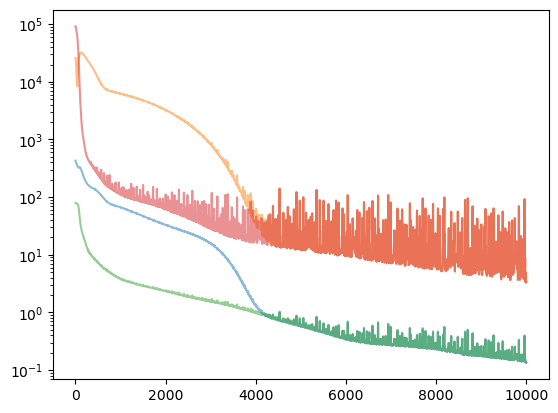

In [18]:
plt.plot(losses[:,0], alpha=.5)
plt.plot(losses[:,1], alpha=.5)
plt.plot(losses[:,2], alpha=.5)
plt.plot(losses[:,3], alpha=.5)
plt.yscale('log')
plt.show()

In [20]:
from pde_solvers.cn import *

In [21]:
simulation = pattern.simulation
model_2D = RD_2D_1st_Order(Ds = simulation.Ds,
                           N=simulation.t_steps*100,
                           T=simulation.t_end,
                           Lx=simulation.L[0],
                           Ix=simulation.n[0]-1,
                           Ly=simulation.L[1],
                           Jy=simulation.n[1]-1,
                           boundary_condition=Periodic_Boundary_2D)

In [22]:
pattern_end = load(sim_name, x_slice, y_slice,
               data_time_start=3,
               data_time_len=2,
               data_time_step=1)
U0 = pattern_end.c_domain[0, ..., 0].flatten()
V0 = pattern_end.c_domain[1, ..., 0].flatten()

In [23]:
rho_uE, sigma_uE, mu_uE, kappa_uE, rho_vE, sigma_vE = (rho_u.numpy(), sigma_u.numpy(),
                                                       mu_u.numpy(), kappa_u.numpy(),
                                                       rho_v.numpy(), sigma_v.numpy())
def Koch_Meinhardt(u,v):        
    u2 = u**2
    u2v = u2 * v
    u2v_u2 = u2v / (1.0 + kappa_uE * u2)
    fu = rho_uE * u2v_u2 - mu_uE * u + sigma_uE
    fv = -rho_vE * u2v_u2 + sigma_vE
    return fu, fv

In [24]:
model_2D_result = model_2D.integrate([U0, V0], Koch_Meinhardt,record_steps=100)

In [25]:
model_2D_result.shape

(641, 2, 10000)

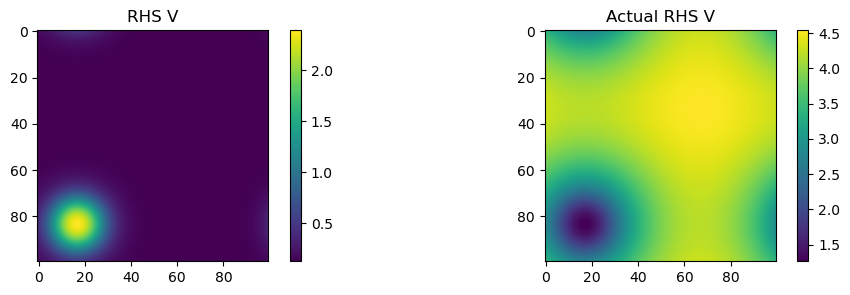

In [26]:
plot_n_im([model_2D_result[-1, 0, :].reshape(100,100),  model_2D_result[-1, 1, :].reshape(100,100)],
           ["RHS V", "Actual RHS V"],          
           figsize=(12, 3));

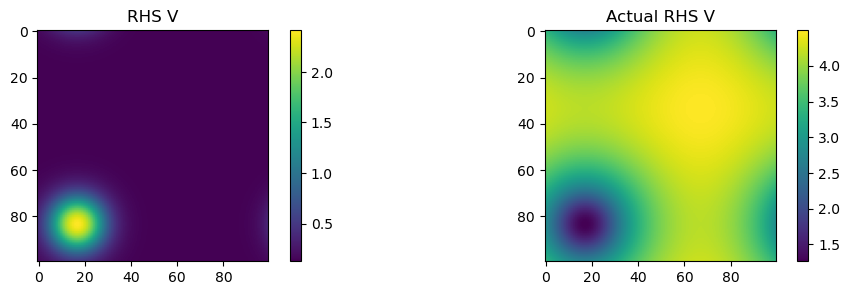

In [27]:
plot_n_im([pattern.c[0, ..., -1],  pattern.c[1, ..., -1]],
           ["RHS V", "Actual RHS V"],          
           figsize=(12, 3));